In [15]:
import torch
from torch import optim
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from einops import repeat

import pandas as pd
from scipy.stats import binom

from utils.data import *
from common.res_infor import *
from utils.dataset import *
from diffusion_model.sequence_diffusion_model import *
from benchmark.sequence_metric import sequence_recovery_rate

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 100
LEARNING_RATE = 1e-3
fixed_length = 16

In [4]:
# Load data
train_data = pd.read_csv('./data/train_data.csv')
test_data = pd.read_csv('./data/test_data.csv')

In [5]:
# subsample data
train_data = subsample_protein_data(train_data, fixed_length=fixed_length)
test_data = subsample_protein_data(test_data, fixed_length=fixed_length)

In [6]:
# Data loader
train_dataset = ProteinDataset(train_data)
test_dataset = ProteinDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)

# Print some Sequence data

In [7]:
# print some Sequence data
def tensor_to_string(tensor, label_res_dict):
    sequences = []
    for i in range(tensor.size(0)):
        sequence = ""
        for residue in tensor[i]:
            if residue.item() == 0:
                sequence += '-'  # Skip this residue
            elif residue.item() == 21:
                sequence += "*"
            else:
                sequence += label_res_dict[residue.item()]
        sequences.append(sequence)
    return sequences
    
for batch_idx, (pdb_id, res, atom_coords, mask) in enumerate(train_loader):
    sequences = tensor_to_string(res, label_res_dict)
    print(pdb_id[:5])
    print(sequences[:5])
    break

("('1ldj', 'A')", "('3f6c', 'A')", "('3cip', 'A')", "('1dbh', 'A')", "('1j3m', 'A')")
['LDQIWDDLRAGIQQVY', 'SLNAIIIDDHPLAIAA', 'VQALVIDNGSGMCKAG', 'EQTYYDLVKAFAEIRQ', 'GMRKTLKATLAEARAQ']


# Visualization of the forward process

In [8]:
# Visualization of the forward process
diffusion = SequenceDiffusion(res_num=fixed_length)

pdb_id, res, _, _= next(iter(train_loader))
pdb_1 = pdb_id[0]
x_t = res[0].reshape(1, -1)
print(pdb_1)

for t in range(0, 101, 10):
    t = torch.tensor([t])
    x_t, _, _= diffusion.seq_q_sample(x_t, t)
    sequences = tensor_to_string(x_t, label_res_dict)
    print(f"t = {t.item()}:", sequences)

('2q7a', 'A')
t = 0: ['MDKGQIYGSIIQRNYR']
t = 10: ['MDKGQIYGSIIQRN*R']
t = 20: ['*DKGQIY*SIIQRN*R']
t = 30: ['**KGQIY*****RN*R']
t = 40: ['**KGQI******R**R']
t = 50: ['*****I*********R']
t = 60: ['*****I**********']
t = 70: ['****************']
t = 80: ['****************']
t = 90: ['****************']
t = 100: ['****************']


# Model training

In [9]:
diffusion = SequenceDiffusion(res_num=fixed_length, device=DEVICE)
model = SequenceModel().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)

In [17]:
loss_history = []
for epoch in range(EPOCH):    
    model.train()
    train_loss = 0
    for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(train_loader, leave=False)):
        # Data preparation
        x_0 = res_label.to(DEVICE)
        x_0 = x_0.to(torch.float32)
    
        n_coords = atom_coords[:, :, 0]
        ca_coords = atom_coords[:, :, 1]
        c_coords = atom_coords[:, :, 2]

        pair_repr = torch.cdist(ca_coords, ca_coords, p=2)
        rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
        
        # Foward Diffusion
        batch_size = atom_coords.shape[0]
        t, pt = diffusion.sample_timesteps(batch_size = batch_size, device=DEVICE)

        x_t, x_0_ignore, mask = diffusion.seq_q_sample(x_0, t)
        
        # Backward Diffusion
        x_0_hat_logits = model(x_t, pair_repr.to(DEVICE, torch.float32), rotations.to(DEVICE,torch.float32), translations.to(DEVICE, torch.float32))
        
        
        
        # Custom loss function
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.transpose(1, 2), 
                                             x_0_ignore.to(torch.int64), 
                                             ignore_index = -1, reduction='none')
        
        cross_entropy_loss = torch.sum(cross_entropy_loss, dim=1)

        vb_loss = cross_entropy_loss / t

        vb_loss = vb_loss / pt
        
        loss = vb_loss.mean()

        optimizer.zero_grad()
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    avg_loss = train_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, avg_loss))

====> Epoch: 0 Average loss: 0.3460903548


====> Epoch: 1 Average loss: 0.3319926932


====> Epoch: 2 Average loss: 0.3245090068


====> Epoch: 3 Average loss: 0.3191331991


====> Epoch: 4 Average loss: 0.3163530108


====> Epoch: 5 Average loss: 0.3140725874


====> Epoch: 6 Average loss: 0.3128597781


====> Epoch: 7 Average loss: 0.3123410245


====> Epoch: 8 Average loss: 0.3112907046


====> Epoch: 9 Average loss: 0.3087270296


====> Epoch: 10 Average loss: 0.3081416121


====> Epoch: 11 Average loss: 0.3077657729


====> Epoch: 12 Average loss: 0.3053580696


====> Epoch: 13 Average loss: 0.3050264772


====> Epoch: 14 Average loss: 0.3054630124


====> Epoch: 15 Average loss: 0.3024928519


====> Epoch: 16 Average loss: 0.3031590306


====> Epoch: 17 Average loss: 0.3017780607


====> Epoch: 18 Average loss: 0.3032488690


====> Epoch: 19 Average loss: 0.3023768404


====> Epoch: 20 Average loss: 0.3018415694


====> Epoch: 21 Average loss: 0.3006895073


====> Epoch: 22 Average loss: 0.2982219932


====> Epoch: 23 Average loss: 0.2992866715


====> Epoch: 24 Average loss: 0.2999059087


====> Epoch: 25 Average loss: 0.2989501969


====> Epoch: 26 Average loss: 0.2980559668


====> Epoch: 27 Average loss: 0.2982531365


====> Epoch: 28 Average loss: 0.2972076239


====> Epoch: 29 Average loss: 0.2965323601


====> Epoch: 30 Average loss: 0.2964891492


====> Epoch: 31 Average loss: 0.2980420666


====> Epoch: 32 Average loss: 0.2964782311


====> Epoch: 33 Average loss: 0.2962444673


====> Epoch: 34 Average loss: 0.2981540539


====> Epoch: 35 Average loss: 0.2959734621


====> Epoch: 36 Average loss: 0.2942953906


====> Epoch: 37 Average loss: 0.2941845073


====> Epoch: 38 Average loss: 0.2944126939


====> Epoch: 39 Average loss: 0.2966698254


====> Epoch: 40 Average loss: 0.2928641762


====> Epoch: 41 Average loss: 0.2942011622


====> Epoch: 42 Average loss: 0.2936451345


====> Epoch: 43 Average loss: 0.2933226011


====> Epoch: 44 Average loss: 0.2944115740


====> Epoch: 45 Average loss: 0.2926186309


====> Epoch: 46 Average loss: 0.2939227166


====> Epoch: 47 Average loss: 0.2935051598


====> Epoch: 48 Average loss: 0.2929167739


====> Epoch: 49 Average loss: 0.2930608542


====> Epoch: 50 Average loss: 0.2921673224


====> Epoch: 51 Average loss: 0.2911168541


====> Epoch: 52 Average loss: 0.2903940714


====> Epoch: 53 Average loss: 0.2915121304


====> Epoch: 54 Average loss: 0.2912986661


====> Epoch: 55 Average loss: 0.2914025711


====> Epoch: 56 Average loss: 0.2921066962


====> Epoch: 57 Average loss: 0.2896903823


====> Epoch: 58 Average loss: 0.2895371620


====> Epoch: 59 Average loss: 0.2905709517


====> Epoch: 60 Average loss: 0.2896169176


====> Epoch: 61 Average loss: 0.2904299811


====> Epoch: 62 Average loss: 0.2906320042


====> Epoch: 63 Average loss: 0.2896505491


====> Epoch: 64 Average loss: 0.2923819861


====> Epoch: 65 Average loss: 0.2889340358


====> Epoch: 66 Average loss: 0.2913346379


====> Epoch: 67 Average loss: 0.2894098327


====> Epoch: 68 Average loss: 0.2891096243


====> Epoch: 69 Average loss: 0.2899193102


====> Epoch: 70 Average loss: 0.2896975107


====> Epoch: 71 Average loss: 0.2893274109


====> Epoch: 72 Average loss: 0.2910581321


====> Epoch: 73 Average loss: 0.2897118419


====> Epoch: 74 Average loss: 0.2896560193


====> Epoch: 75 Average loss: 0.2887703235


====> Epoch: 76 Average loss: 0.2885069803


====> Epoch: 77 Average loss: 0.2889518439


====> Epoch: 78 Average loss: 0.2904189998


====> Epoch: 79 Average loss: 0.2883116846


====> Epoch: 80 Average loss: 0.2891281854


====> Epoch: 81 Average loss: 0.2900087171


====> Epoch: 82 Average loss: 0.2882887967


====> Epoch: 83 Average loss: 0.2879259983


====> Epoch: 84 Average loss: 0.2881232890


====> Epoch: 85 Average loss: 0.2882973792


====> Epoch: 86 Average loss: 0.2897781675


====> Epoch: 87 Average loss: 0.2887970900


====> Epoch: 88 Average loss: 0.2873398735


====> Epoch: 89 Average loss: 0.2874197545


====> Epoch: 90 Average loss: 0.2869179005


====> Epoch: 91 Average loss: 0.2887616391


====> Epoch: 92 Average loss: 0.2871722826


====> Epoch: 93 Average loss: 0.2875583155


====> Epoch: 94 Average loss: 0.2873966858


====> Epoch: 95 Average loss: 0.2861580778


====> Epoch: 96 Average loss: 0.2883290549


====> Epoch: 97 Average loss: 0.2881516660


====> Epoch: 98 Average loss: 0.2869076971


====> Epoch: 99 Average loss: 0.2874965078


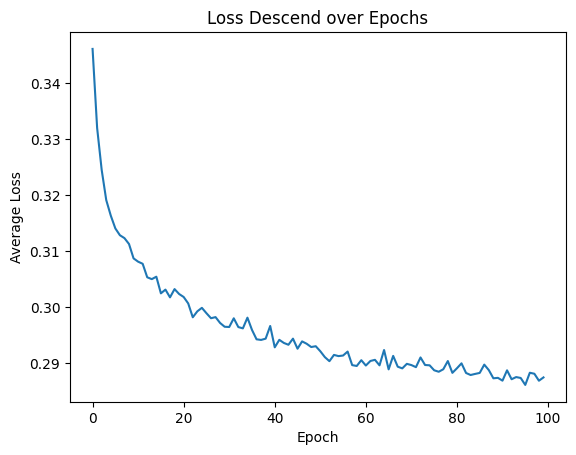

In [18]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Descend over Epochs')
plt.show()

In [15]:
# save the model
torch.save(model.state_dict(), './trained_models/sequence_model_16.pt')

# Sample one sequence

In [9]:
# load the model
DEVICE = torch.device('cpu')
model = SequenceModel()
model.load_state_dict(torch.load('./trained_models/sequence_model_16.pt', map_location=DEVICE))

<All keys matched successfully>

In [10]:
# sample
model.eval()
batch_size = 1
seq_length = fixed_length

# groud truth sequence
pdb_id, res, atom_coords,  mask = next(iter(test_loader))
atom_coords = atom_coords.to(torch.float32)

n_coords = atom_coords[:, :, 0]
ca_coords = atom_coords[:, :, 1]
c_coords = atom_coords[:, :, 2]

rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

mask = mask.bool()

sequences = tensor_to_string(res, label_res_dict)
print("PDB ID:",pdb_id[0])

# prepare data, only generate one sequence corresponding to ground truth backbone structure
x_t = torch.ones(batch_size, seq_length, device=DEVICE, dtype=torch.int64) * 21

rotation = rotations[0].unsqueeze(0)
translation = translations[0].unsqueeze(0)
rotation = rotation.to(DEVICE)
translation = translation.to(DEVICE)
pair_repr = pair_repr[0].unsqueeze(0)

mask = mask[0].unsqueeze(0).to(DEVICE)

unmasked = torch.zeros_like(x_t, device=DEVICE).bool()
sample_steps = list(range(1, 100+1))

# sample
for t in reversed(sample_steps):
  t = torch.full((batch_size,), t, device=DEVICE, dtype=torch.int64)
  # where to unmask
  t_mask = t.reshape(batch_size, 1)
  t_mask = t_mask.expand(batch_size, seq_length)

  changes = torch.rand_like(x_t.float()) < 1 / t_mask.float()
  changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
  
  # update mask with changes
  unmasked = torch.bitwise_or(unmasked, changes)
  
  x_0_logits = model(x_t.float(), pair_repr, rotation, translation)
  index = torch.argmax(x_0_logits, dim=2)

  x_t.long()[changes] = index.long()[changes]

  x_t = x_t * mask # mask out the padding
  
  sequence = tensor_to_string(x_t, label_res_dict)
  print(print(f"t = {t.item()}:", sequence))

print("ground truth sequence is:", sequences[0])

PDB ID: ('1a0j', 'A')
t = 100: ['************************V***************************************']
None
t = 99: ['************************V***************************************']
None
t = 98: ['************************V***************************************']
None
t = 97: ['************************V***************************************']
None
t = 96: ['************************V***************************************']
None
t = 95: ['************************V****************A**********************']
None
t = 94: ['************************V****************A**********************']
None
t = 93: ['***************A********V***************DA**********************']
None
t = 92: ['***************A********V***************DA**********************']
None
t = 91: ['********E******A********V***************DA**********************']
None
t = 90: ['*E****P*E******A********V***************DA**********************']
None
t = 89: ['*E****P*E******A********V***************DA**********************'

# Sequence recovery rate on test set

In [39]:
model.eval()
sequence_recovery_rate_list = []

for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(test_loader)):
    # Data preparation
    batch_size = res_label.shape[0]
    
    atom_coords = atom_coords.to(torch.float32)
    n_coords = atom_coords[:, :, 0]
    ca_coords = atom_coords[:, :, 1]
    c_coords = atom_coords[:, :, 2]

    rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
    pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

    mask = mask.bool()
    
    x_t = diffusion.p_sample(model, batch_size, DEVICE, pair_repr, rotations.to(DEVICE), translations.to(DEVICE))
    accuracy = sequence_recovery_rate(x_t, res_label, mask)
    accuracy = torch.mean(accuracy)
    sequence_recovery_rate_list.append(accuracy.item())
        

100%|██████████| 35/35 [54:57<00:00, 94.21s/it]


In [41]:
print("the mean of sequence recovery rate:", np.mean(sequence_recovery_rate_list))
print("the std of sequence recovery rate:", np.std(sequence_recovery_rate_list))

the mean of sequence recovery rate: 0.27018554721559795
the std of sequence recovery rate: 0.013461152883705875


In [42]:
total_data.append(sequence_recovery_rate_list)

In [58]:
# save total data in npy file
total_data = np.array(total_data)
np.save('./data/sequence_recovery_rate_testset.npy', total_data)

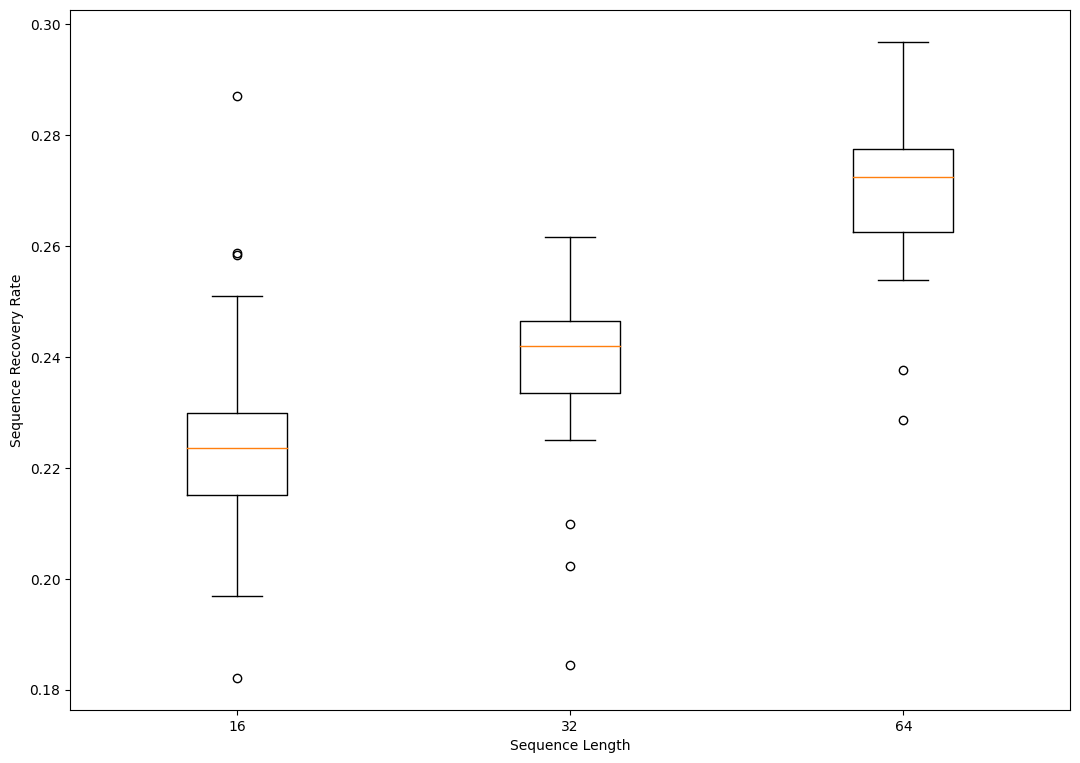

In [60]:
total_data = total_data.tolist()

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
ax.boxplot(total_data)
ax.set_xticklabels(['16', '32', '64'])
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Sequence Recovery Rate')
# show plot
plt.show()

# Sequence recovery rate on 4 test examples with 64 amino acids

In [18]:
test_samples = ["('1acf', 'A')", "('1bkr', 'A')", "('1cc8', 'A')", "('3mx7', 'A')"]
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)
result_dict = {}

# get above four pdb data
for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(test_loader)):
    pdb = pdb[0]
    if pdb in test_samples:
        print(pdb)
        accuracy_list = []
        for i in range(100):
            batch_size = res_label.shape[0]
            atom_coords = atom_coords.to(torch.float32)
            n_coords = atom_coords[:, :, 0]
            ca_coords = atom_coords[:, :, 1]
            c_coords = atom_coords[:, :, 2]

            rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
            pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

            mask = mask.bool()
            
            x_t = diffusion.p_sample(model, batch_size, DEVICE, pair_repr, rotations.to(DEVICE), translations.to(DEVICE))
            accuracy = sequence_recovery_rate(x_t, res_label, mask)
            accuracy_list.append(accuracy.item())
        result_dict[pdb] = accuracy_list
        
    

  0%|          | 0/4372 [00:00<?, ?it/s]

('1acf', 'A')


  0%|          | 10/4372 [03:52<28:08:27, 23.22s/it]

('1bkr', 'A')


  1%|          | 49/4372 [07:44<10:17:57,  8.58s/it]

('1cc8', 'A')


 57%|█████▋    | 2511/4372 [11:33<03:39,  8.49it/s] 

('3mx7', 'A')


100%|██████████| 4372/4372 [15:25<00:00,  4.72it/s]


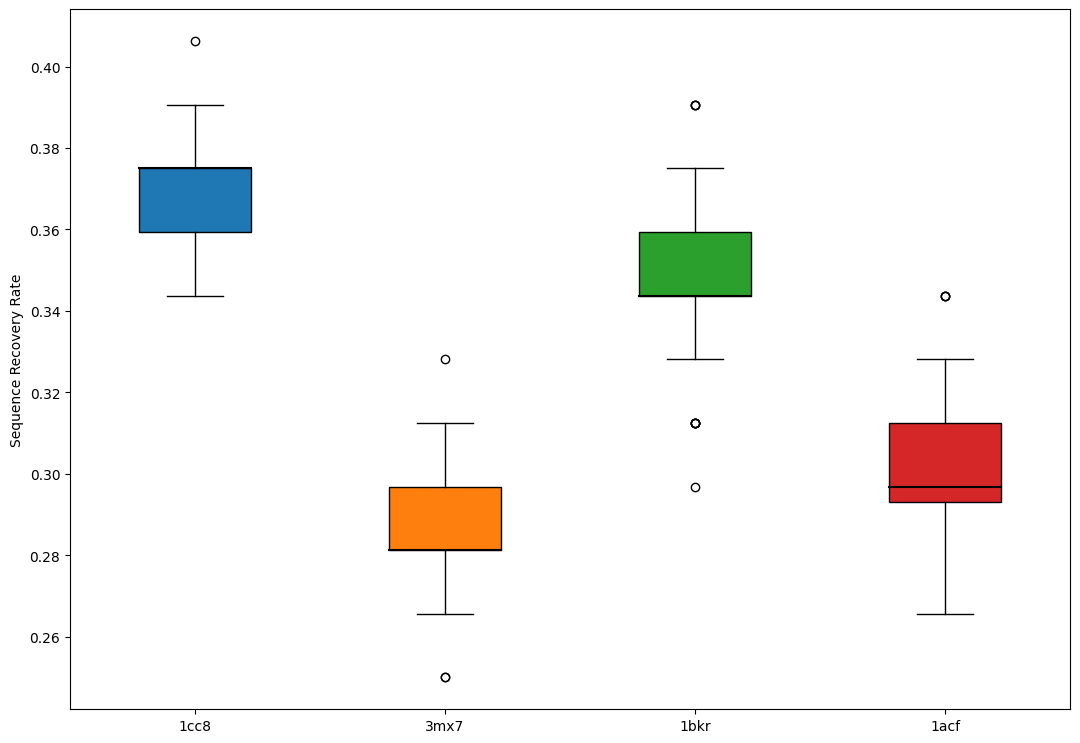

In [33]:
result_data = [result_dict["('1cc8', 'A')"], result_dict["('3mx7', 'A')"], result_dict["('1bkr', 'A')"], result_dict["('1acf', 'A')"]]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Define colors for the boxes
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create the boxplots with custom colors
boxplot = ax.boxplot(result_data, patch_artist=True, medianprops=dict(color="black",linewidth=1.5))

for patch, color in (zip(boxplot['boxes'], colors)):
    patch.set_facecolor(color)

# Creating plot
ax.set_xticklabels(['1cc8', '3mx7', '1bkr', '1acf'])
ax.set_ylabel('Sequence Recovery Rate')
# show plot
plt.show()

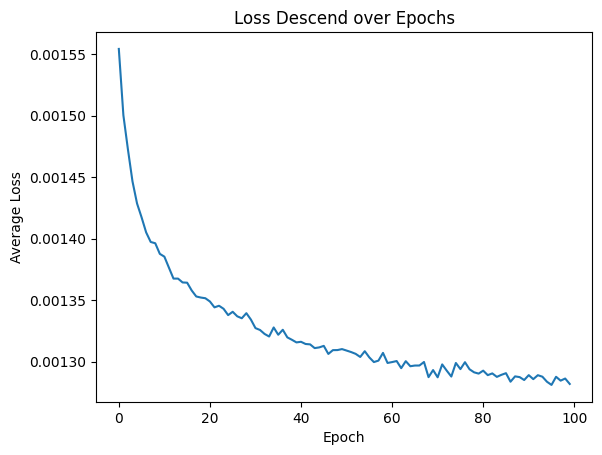

In [8]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Descend over Epochs')
plt.show()

In [9]:
# save the model
torch.save(model.state_dict(), './trained_models/sequence_model_pairwise.pt')

In [17]:
# sample
model.eval()
batch_size = 1
seq_length = 20

# groud truth sequence
pdb_id, res, atom_coords = next(iter(test_loader))
atom_coords = atom_coords.to(torch.float32)
n_coords = atom_coords[:, :, 0]
ca_coords = atom_coords[:, :, 1]
c_coords = atom_coords[:, :, 2]
rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

res = res.squeeze()
sequences = tensor_to_string(res, label_res_dict)
print("PDB ID:",pdb_id[0])

# prepare data, only generate one sequence corresponding to ground truth backbone structure
x_t = torch.ones(batch_size, seq_length, device=DEVICE, dtype=torch.int64) * 21

rotation = rotations[0].unsqueeze(0)
translation = translations[0].unsqueeze(0)
rotation = rotation.to(DEVICE)
translation = translation.to(DEVICE)
pair_repr = pair_repr[0].unsqueeze(0)

#rotations = repeat(torch.eye(3), 'r1 r2 -> b n r1 r2', b = batch_size, n = seq_length)
#translations  = torch.randn(batch_size, seq_length, 3, device=DEVICE)
unmasked = torch.zeros_like(x_t, device=DEVICE).bool()
sample_steps = list(range(1, 100+1))

# sample
for t in reversed(sample_steps):
  t = torch.full((batch_size,), t, device=DEVICE, dtype=torch.int64)
  # where to unmask
  t_mask = t.reshape(batch_size, 1)
  t_mask = t_mask.expand(batch_size, 20)

  changes = torch.rand_like(x_t.float()) < 1 / t_mask.float()
  changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
  
  # update mask with changes
  unmasked = torch.bitwise_or(unmasked, changes)
  x_0_logits = model(x_t.float(), pair_repr, rotation, translation)
  index = torch.argmax(x_0_logits,dim=2)

  x_t.long()[changes] = index.long()[changes]

  sequence = tensor_to_string(x_t, label_res_dict)
  print(print(f"t = {t.item()}:", sequence))

print("ground truth sequence is:", sequences[0])

PDB ID: 1hxvA
t = 100: ['********************']
None
t = 99: ['********************']
None
t = 98: ['********************']
None
t = 97: ['********************']
None
t = 96: ['*************L******']
None
t = 95: ['*************L******']
None
t = 94: ['********K****L******']
None
t = 93: ['********K****L******']
None
t = 92: ['********K****L******']
None
t = 91: ['********K****L******']
None
t = 90: ['********K****L******']
None
t = 89: ['********K****L******']
None
t = 88: ['********K****L******']
None
t = 87: ['********K****L******']
None
t = 86: ['********K****L******']
None
t = 85: ['********K****L******']
None
t = 84: ['********K****L******']
None
t = 83: ['********K****L******']
None
t = 82: ['********K****L******']
None
t = 81: ['********K****L****S*']
None
t = 80: ['********K****L****S*']
None
t = 79: ['********K****L****S*']
None
t = 78: ['********K****L****S*']
None
t = 77: ['********K****L**N*S*']
None
t = 76: ['********K****L**N*S*']
None
t = 75: ['********K****L**N*S*']
No